In [1]:
%load_ext autoreload
%autoreload 2

In [15]:
from src.data import Dataset
from src.trainer import Trainer
from src.utils import set_seed

import torch
import torch.nn as nn
device = torch.device("mps" if torch.mps.is_available() else "cpu")

from tqdm import tqdm
import itertools

# Package & visualize data
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Experiment: 

It would be interseting to see if we keep the same performance as we scale the depth. In `1width.ipynb`, we were looking at a single layer NN.


In [16]:
class MLP(nn.Module):
    '''
    1-Hidden Layer MLP for testing Kernel Regime

    Assumptions:
        - Input is MNIST images of size 28x28
        - Output is 10 classes + auxiliary_logits
    '''
    def __init__(self, 
        hidden_width: int, 
        auxiliary_logits: int, 
        depth: int = 1,
        dropout: float = 0.0
    ):
        super(MLP, self).__init__()
        layers = []
        input_dim = 28*28
        for i in range(depth):
            layers.append(nn.Linear(input_dim, hidden_width))
            layers.append(nn.ReLU())
            input_dim = hidden_width
        layers.append(nn.Linear(hidden_width, 10 + auxiliary_logits))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        x = self.net(x)
        return x

def init_models(hidden_width: int, 
                auxiliary_logits: int, 
                depth: int):
    teacher = MLP(hidden_width, auxiliary_logits, depth)
    student = MLP(hidden_width, auxiliary_logits, depth)
    student.load_state_dict(teacher.state_dict())
    return teacher, student

In [17]:
def run(hidden_width: int, 
        auxiliary_logits: int, 
        depth: int, 
        seed: int = 42):
  # Seed
  g = set_seed(seed)

  # Initalize Network
  teacher, student = init_models(hidden_width=hidden_width, auxiliary_logits=auxiliary_logits, depth=depth)
  # teacher = torch.compile(teacher)
  # student = torch.compile(student)

  # Training Parameters
  epochs = 5
  lr = 0.001
  optimizer_teacher = torch.optim.Adam(teacher.parameters(), lr=lr)
  optimizer_student = torch.optim.Adam(student.parameters(), lr=lr)
  criterion_teacher = nn.CrossEntropyLoss()
  criterion_student = nn.MSELoss()

  batch_size = 128
  train_loader, test_loader = Dataset.load_FashionMNIST(batch_size=batch_size, seed=seed)

  # Run Training
  trainer = Trainer(student, teacher, train_loader, optimizer_teacher, optimizer_student, criterion_teacher, criterion_student, device)

  baseline_teacher = trainer.performance(trainer.teacher, test_loader)
  baseline_student = trainer.performance(trainer.student, test_loader)

  print('Start Training')
  trainer.train_teacher(epochs)
  trainer.train_student(epochs)
  print('Finished Training')

  results_teacher = trainer.performance(trainer.teacher, test_loader)
  results_student = trainer.performance(trainer.student, test_loader)

  del teacher, student, trainer, optimizer_student, optimizer_teacher
  torch.cuda.empty_cache()

  return baseline_teacher, baseline_student, results_teacher, results_student

In [21]:
width = 128
auxiliary = 10
depths = list(range(2, 10, 2))

results = []
for i in tqdm(depths):
    result = run(hidden_width=width, auxiliary_logits=auxiliary, depth=i)
    results.append(result)

  0%|          | 0/4 [00:00<?, ?it/s]

Start Training


Avg Loss: 0.604755543569512


Avg Loss: 0.4059394456303196


Avg Loss: 0.36394121210331093


Avg Loss: 0.3346973202630147


100%|██████████| 5/5 [00:10<00:00,  2.20s/it]


Avg Loss: 0.3207313587416464


Avg Loss: 0.053495270924877


Avg Loss: 0.008616970656419804


Avg Loss: 0.005994925358847006


Avg Loss: 0.004803989550221894


 25%|██▌       | 1/4 [00:21<01:04, 21.37s/it]

Avg Loss: 0.004130877970930324
Finished Training
Start Training


Avg Loss: 0.678828879333


 25%|██▌       | 1/4 [00:25<01:15, 25.03s/it]


KeyboardInterrupt: 

100%|██████████| 5/5 [00:00<00:00, 108660.73it/s]


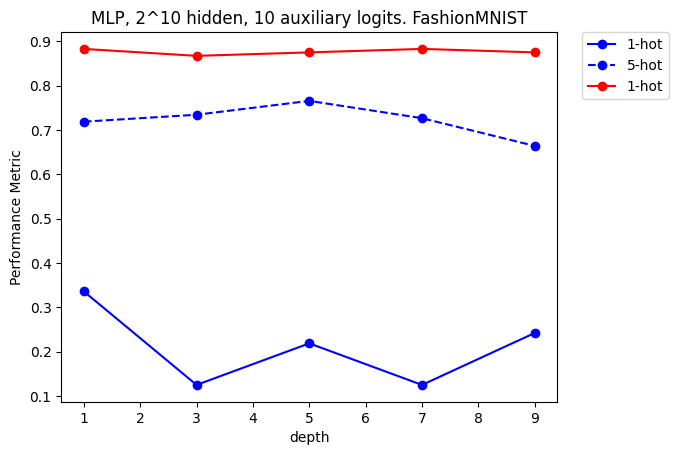

In [14]:
acc_1hot_student = []
acc_5hot_student = []
acc_1hot_teacher = []
depths = list(range(1, 10, 2))


for result in tqdm(results):
    baseline_teacher, baseline_student, results_teacher, results_student = result
    acc_1hot_student.append(results_student['acc_1hot'])
    acc_5hot_student.append(results_student['acc_5hot'])
    acc_1hot_teacher.append(results_teacher['acc_1hot'])

plt.plot(depths, acc_1hot_student, label='1-hot', marker='o', color='blue')
plt.plot(depths, acc_5hot_student, label='5-hot', marker='o', color='blue', linestyle='--')
plt.plot(depths, acc_1hot_teacher, label='1-hot', marker='o', color='red')
plt.xlabel('depth')
plt.ylabel('Performance Metric')
plt.title('MLP, 2^10 hidden, 10 auxiliary logits. FashionMNIST')
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)
plt.show()